
Time Series Analysis (TSA) in the Finance
================


Igor Marfin < <igor.marfin@unister.de>>


Abstract
----------------




--------------------------

By these lectures, I want to make a simple introduction on the time series analysis, which will include:

* Motivation
* Introduction to Geometric Brownian motion
* Introduction to Autoregressive and Moving-average models
* ARMA (= Autoregressive + Moving-average ) model
* Basics of Statistical Mean Reversion Testing
  * Augmented Dickey-Fuller (ADF) Test
  * Generalized Hurst Exponent as the Testing for Stationarity
  * ACF and PACF  
  * Fit of the ARMA model
    * Goodness of the Fit: Residual tests
        * a QQ-plot
        * D'Agostino's K-squared test 
        * Durbin–Watson statistic  test 
        * Ljung–Box test of the autocorrelations
* Seasonal decomposition
* Forecasting using ARMA
* Forecasts using ARIMA (Autoregressive integrated moving average) models, if I am in a mood

  



Initialization 
--------------------------

________


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline
ion()

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats





# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from book_format import load_style, figsize, set_figsize
load_style()



Populating the interactive namespace from numpy and matplotlib


Motivation
--------------------

------------


My studies start from motivations and aims I want to achieve.  Motivation is simple:

>* predict values of  stochastic price assets;
* determine at what stage (stationary or non-stationary) the assest is;
  
What concerns to aims, hm-m-m, I would say, they are semi-academic, this project is my self-education, as well as semi-business, this is a part of  my future business intelligence framework intended to work not only on stock markets with price assets, but also to solve typical business tasks related to seasonal product sellings.







Introduction to Geometric Brownian motion 
--------------------------------------


------------------------




The reason of consideration of the Geometric Brownian Motion (GBM) and a few examples of GBM are given in [stochastic-brownian-motion.ipynb](stochastic-brownian-motion.ipynb).


Introduction to Autoregressive and Moving-average models
--------------------------------------


------------------------

Well, the autoregressive and moving-average models were introduced in the previos section. But it would be useful to get a few practical examples of applications for  these models. First, we consider the Autoregressive model, $AR(p)$ [[1]](#AR).



The notation AR(p) refers to the autoregressive model of order p. The AR(p) model is written
$$X_t = c + \sum_{i=1}^p \varphi_i X_{t-i}+ \varepsilon_t , $$
where $\varphi_1, \ldots, \varphi_p$ are parameters, $c$ is a constant, and the random variable $\varepsilon_t$ is white noise. For simplicity sake, we consider AR(1).


> For instance, let’s say $X_t$ is the number of juice bottles sold in a city on a particular day.  During winters, very few vendors purchased juice bottles. Suddenly, on a particular day, the temperature rose and the demand of juice bottles soared to 1000.
But, knowing that the people got used to drinking juice during the hot days, there were about 50% of the people still drinking juice during the cold days. In following days, the proportion went down to about 25% (50% of 50%) and then gradually to a small number after significant number of days. 

To model this situation, we choose the following formula

$$ X_t = 0.5*X_{t-1} + \varepsilon_t. $$

Also, please, pay an attention to **about**. This **about** is formulated as a white noise $ \varepsilon_t.$


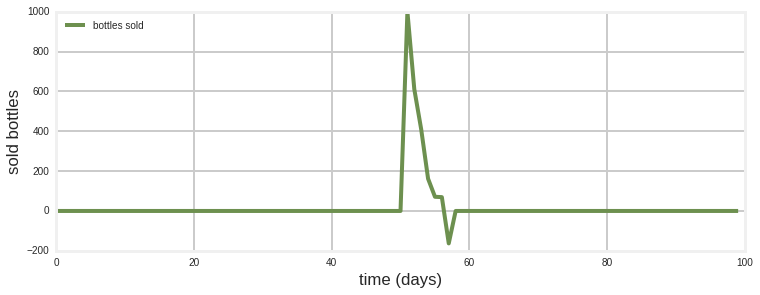

In [5]:
from numpy.random import standard_normal
from numpy import array, zeros, sqrt, shape
from pylab import *


def ar1(x_0=1e3,sudden_day=50.,T=100,dt=1e0, alpha=0., sigma=1e1):
    ''' generate the ar(1) process '''
    
    
    Steps=round(T/dt); #Steps in years
    S = zeros([Steps], dtype=float)
    x = range(0, int(Steps), 1)

    
    S[0] = 0.
    for i in x[:-1]:
        if ((S[i] == 0.) and  (x[i]>sudden_day)   ):
            S[i] = x_0
        if (x[i]<=sudden_day):
             S[i+1] =0.
        else:
            if (S[i]>=1e-1*sigma):
                S[i+1]=S[i]*alpha+sigma*standard_normal();
            else:
                S[i+1] = 1e-2
    
    plot(x, S,label='bottles sold')
    xlabel('time (days)')
    ylabel('sold bottles')
    legend(loc="upper left")
    show()    
    return S
    

# unusual  hit of temperature on 50th day
ar1_data=ar1(x_0=1e3,sudden_day=50.,T=100,dt=1e0, alpha=0.5, sigma=1e2)

In [44]:
%history -f ar1.py -l 1

File u'ar1.py' exists. Overwrite? y
Overwriting file.


Let’s take another case to understand Moving average time series model [[2]](#MA).

>A manufacturer produces a certain type of bag, which was readily available in the market. Being a competitive market, the sale of the bag stood at zero for many days. So, one day he did some experiment with the design and produced a different type of bag. This type of bag was not available anywhere in the market. Thus, he was able to sell the entire stock of 1000 bags (lets call this as $X_t$ ). The demand got so high that the bag ran out of stock. As a result, some 100 odd customers couldn’t purchase this bag. Lets call this gap as the error at that time point. With time, the bag had lost its woo factor. But still few customers were left who went empty handed the previous day. Following is a simple formulation to depict the scenario :

$$ X_t = 0.5*\varepsilon_{t-1} + \varepsilon_t. $$

0.5 is the factor of losing  customers. $\varepsilon_t \sim N(0,10)$

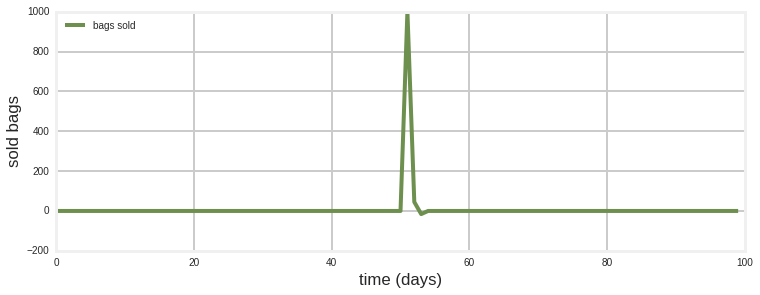

In [3]:
from numpy.random import standard_normal
from numpy import array, zeros, sqrt, shape
from pylab import *


def ma1(x_0=1e3,error_0=1e2,sudden_day=50.,T=100,dt=1e0, alpha=0., sigma=1e1):
    ''' generate the ma(1) process '''
    
    
    Steps=round(T/dt); #Steps in years
    S = zeros([Steps], dtype=float)
    error = zeros([Steps], dtype=float)
    
    x = range(0, int(Steps), 1)

    
    
    S[0] = 0.
    error[0] = 0.
    for i in x[:-1]:
        if ((S[i] == 0.) and  (x[i]>sudden_day)   ):
            S[i] = x_0
            error[i] = error_0
        if (x[i]<=sudden_day):
            S[i+1] =0.
            error[i+1] =0.
        else:
            if (S[i]>=1e-1*sigma):
                error[i+1] = sigma*standard_normal()
                S[i+1]=error[i]*alpha+error[i+1];
        
            else:
                S[i+1] = 1e-2
                error[i+1] = 0.
    
    plot(x, S,label='bags sold')
    xlabel('time (days)')
    ylabel('sold bags')
    legend(loc="upper left")
    show()    
    return S


# 
ma1_data=ma1(x_0=1e3,error_0=1e2,sudden_day=50.,T=100,dt=1e0, alpha=0.5, sigma=1e1)

In [3]:
%history -f ma1.py -l 1

File u'ma1.py' exists. Overwrite? y
Overwriting file.


Once we have got these two stationary time series, we need to answer two primary question:

Q1. Is it an AR or MA process?

Q2. What order of AR or MA process do we need to use?

To answer the question,we have to plot the autocorrelation functions (ACF). If we see 
correlations for some time lags, then we conclude about the process.
If autocorrelations don't have a cut at which they are getting small, this process is AR
otherwise it is a MA process.

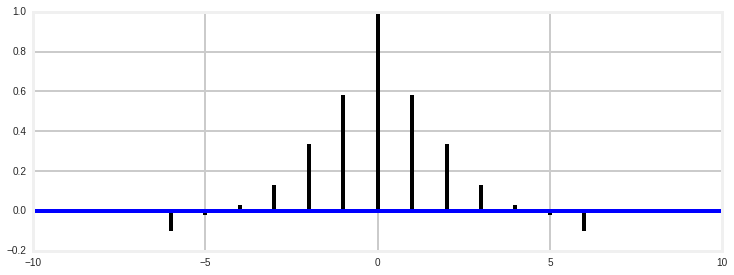

In [6]:
_,_,_,_=pl.acorr(ar1_data)

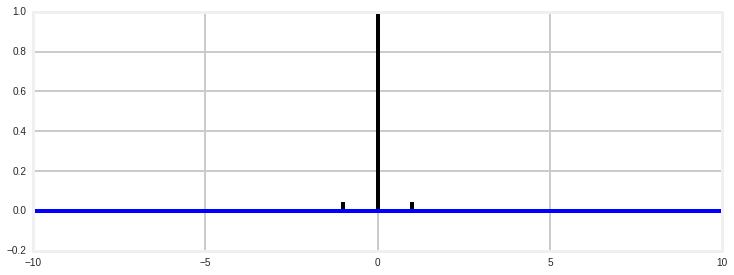

In [5]:
_,_,_,_=pl.acorr(ma1_data)

A1. Yes. They are both processes. The 1st process is AR, the second is MA.

To get the orders of processes, we can find the lag at which the correlation of processes is becoming very small. For MA, the lag is 1. So, that means that MA has the order 1. How do we get the order of AR if its correlation doesn't converge to zero for the significantly large time lags? We need to break autocorrelation series of the AR process, building so called partial autocorrelation functions (PACF) and find the lag after wich the autocorrelation becomes very small.

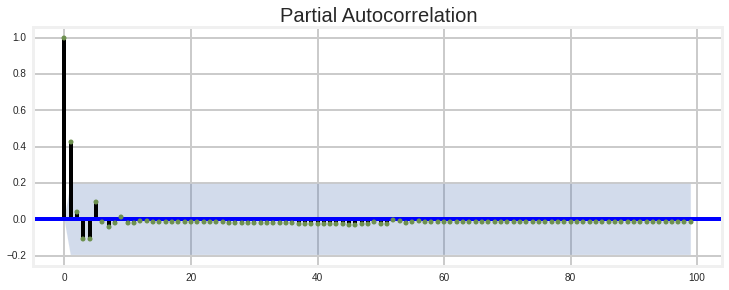

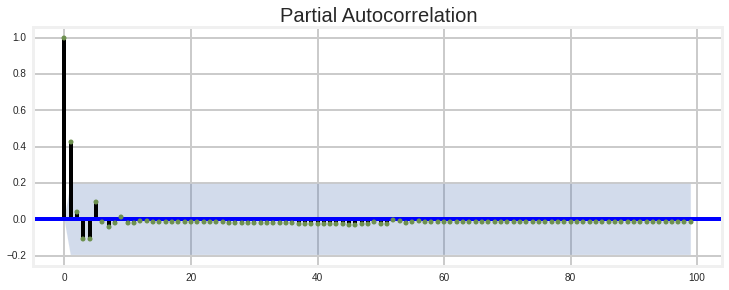

In [6]:
import statsmodels.graphics.tsaplots as tsaplots

tsaplots.plot_pacf(ar1_data)

From the PACF plot for our AR process, we can not conlude exactly about the order: it might be either p=2-1=1 or p=3-1=2, because the hieght of autocorrelations at both lags are almost the same. 

A.2. 

* MA has p=1.

* AR has p=1 or p=2.

ARMA (= Autoregressive + Moving-average ) model
--------------------------------------------------


----------------

As we already know,  ARMA allows to model GBM of the price assets. We can simulate the ARMA
process using `statsmodels`. 


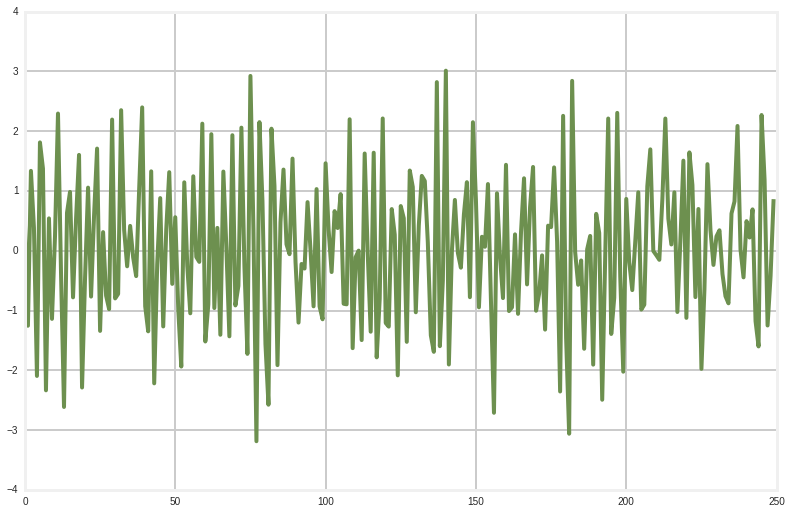

In [7]:
# generation of the ARMA Process
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess



np.random.seed(1234)

def arma_generate(arparams, maparams):
    ''' produce arma process '''
    
    arma_t = ArmaProcess(arparams, maparams)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(arma_t.generate_sample(250));
    return arma_t



# include zero-th lag

arparams = np.array([1, .785, .65])
maparams = np.array([1, .65])

arma_data = arma_generate(arparams,maparams)

In [59]:
%history -f arma.py -l 1

It looks like a stationary process, let's check? 

In [8]:
arma_data.isstationary

True

As an example, this is the  ARMA(-1,1) which characterizes the down-trend.

False

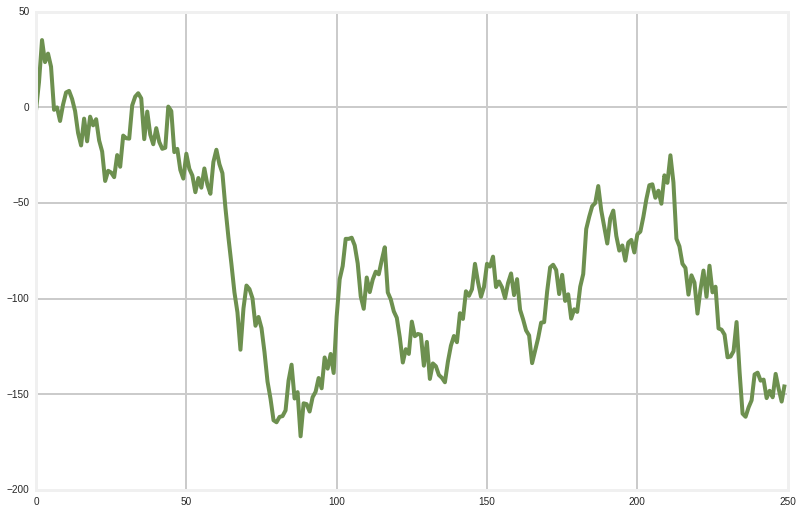

In [26]:
# include zero-th lag
arparams = np.array([1, -1. ])
maparams = np.array([1, -10])
arma_data = arma_generate(arparams,maparams)
arma_data.isstationary

And the ARMA(-1,-2) produces the up-trend.

False

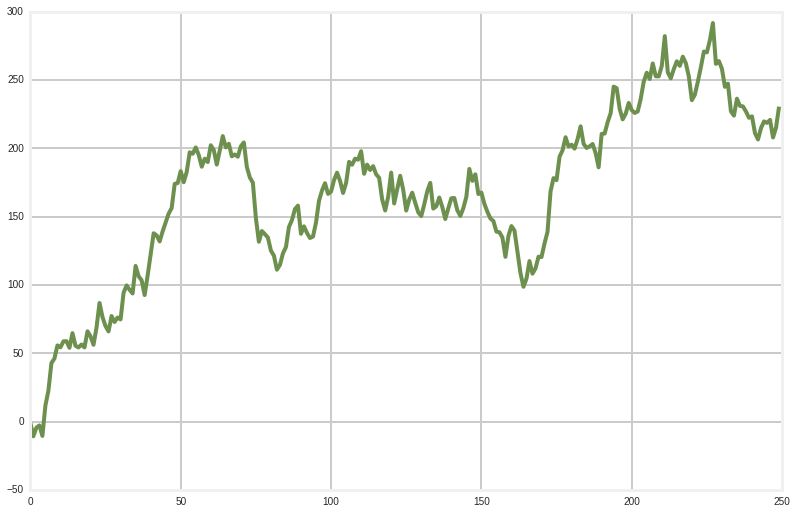

In [25]:
# include zero-th lag
arparams = np.array([1, -1. ])
maparams = np.array([1, 10.])
arma_data = arma_generate(arparams,maparams)
arma_data.isstationary


ARMA model in practice 
--
---------------------


Let's try to make a simple analysis of the trading data. We will investigate the timeseries of close prices of the Google. 

First, let's get the data from Yahoo Finance

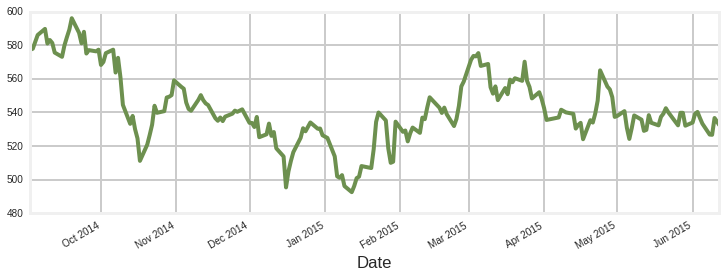

In [2]:
import pandas.io.data as web
import datetime

start = datetime.datetime(2014, 9, 1) # some day in the past
today = datetime.datetime(2015,6,13)  #  today is 13th June of 2015.

data = web.DataReader("GOOG", 'yahoo', start, today)
data['Close'].plot()


We can calculate the returns(, which we want to analyse?). The returns or logarithms of the returns is helpful to make the stationary timeseries. This is one of the ways of the 
Differencing to get the Difference-Stationary Process (DSP).


'Looks like the Stationary Process'

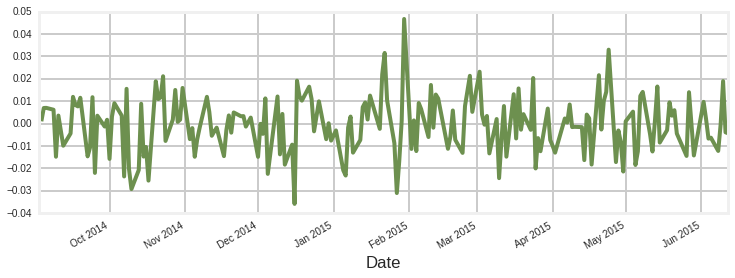

In [8]:
data['Returns'] = data.Close.pct_change()
data['Returns'].plot()
'Looks like the Stationary Process'

Berfore we continue with the modeling of the timeseries, we would like to predict the type of the model: 

* stationary, or non-stationary;
* orders, p and q of  the model, i.e. p and q for ARMA(p,q);





Basics of Statistical Mean Reversion Testing
--

------------
### Stationary test
--------------

This test is also called Augmented Dickey–Fuller (ADF) test [[3]](#ADF).
It has three versions

1. Test for a unit root: $$\nabla y_t =\delta y_{t-1}+u_t \,$$

2. Test for a unit root with drift: $$\nabla y_t =a_0+\delta y_{t-1}+u_t \,$$

3. Test for a unit root with drift and deterministic time trend: $$\nabla y_t = a_0+a_1t+\delta y_{t-1}+u_t \,$$




In [3]:
# Check the 'close price' asset for stationary. Three versions of test are used.
import statsmodels.api as sm
y=data['Close'].values

# test 1
unit_root1 = sm.tsa.adfuller(y,maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 1: ', unit_root1

# test 2
unit_root2 = sm.tsa.adfuller(y,maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 2: ', unit_root2


# test 3
unit_root3 = sm.tsa.adfuller(y,maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 3: ', unit_root3




ADF test 1:  (-0.57076372377296991, 0.46683099612841261, 0, 196, {'5%': -1.9424538551379529, '1%': -2.5772415566430653, '10%': -1.6155321770053293}, 1214.1664597726574)


ADF test 2:  (-2.5488770005672134, 0.10403024843810277, 0, 196, {'5%': -2.876401960790147, '1%': -3.4641612783842191, '10%': -2.5746921001665974}, 1206.7922480097127)


ADF test 3:  (-2.5319861014037004, 0.31215919711828899, 0, 196, {'5%': -3.4331312406289043, '1%': -4.0057171070461708, '10%': -3.1403469799998303}, 1208.6576094107477)


Results show that we can not reject null hypothesis $\delta = 0$, the hypothesis that  this timeseries is NON-stationary. That is the timeseries is a random walk. Also that means that the ARMA modeling of such data would probably fail. We have to use the ARIMA model instead. But assume that it is ARMA process anyway. We will work with this ARMA approximation.

### Generalized Hurst Exponent as the Testing for Stationarity

The idea behind the Hurst Exponent calculation is that we can use the variance of  price series to 
assess the rate of diffusive behaviour.  For an arbitrary time lag τ, the variance is given by
$$S_q = \langle |g(t + \tau) - g(t)|^q \rangle_t \sim \tau^{qH(q)}, \, $$
where $q$ is 2 and $g(t)$ is the price series.

The parameter $H(2)$ is estimated  from the fit of the variance $S_2$ on the data. There are 3 particular
cases for our interest:

* H(2)<0.5 is characteristic for the stationary (mean-reverting) process;
* H(2)=0.5 means that the time series is a  Geometric Brownian Motion;
* H(2)>0.5 corresponds to the trend.

Bellow, the realization of the Generalized Hurst Exponent function is given.


In [9]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract

def HurstExponent(ts,lag_range=100):
    ''' calculates the Generaliyed Hurst Exponent on the Time Series 'ts' '''
    
     # Create the range of lag values
    ts_size = len(ts)
    lags = range(2, lag_range if lag_range <= ts_size else ts_size )
    
    
    # Calculate the array of the variances of the lagged differences (S_2)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# test of HurstExponent


# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)


# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print "Hurst(GBM):   %s" % HurstExponent(gbm)
print "Hurst(MR):    %s" % HurstExponent(mr)
print "Hurst(TR):    %s" % HurstExponent(tr)

Hurst(GBM):   0.502282372382
Hurst(MR):    0.000124415397199
Hurst(TR):    0.955510647483


In [10]:
def HurstStationaryTest(ts,lag_range=100):
    ''' makes a test on the stationarity 
        returns 0 in a case of a Gometric Brownian Motion
        returns 1 in a case of a Mean-Reverting Motion
        returns 2 in a case of a Trending Motion
        returns -1 in a case of some problem
    
    '''
    
    
    hurst_expo = HurstExponent(ts,lag_range)
    if abs(hurst_expo-0.50)<0.25: return 0
    if hurst_expo<0.50: return 1
    if hurst_expo>0.50: return 2
    
    return -1


In [11]:
%history -f hurstExponent.py -l 2

Now we can test the 'GOOG' price asset again,

In [12]:
HurstStationaryTest(data['Close'].values)

0

and we get the same result we have obtained previously with `sm.tsa.adfuller`.
Now let's test the effect of the 'log' function on the making the stationariy of the process.

GBM:  (0.48923267372710272, 0) (0.50184486385698313, 0)
MRM:  (-7.2657728545494067e-05, 1) (5.2291144106149576e-07, 1)
Trend Motion:  (0.95589671764936579, 2) (0.49631499324396144, 0)


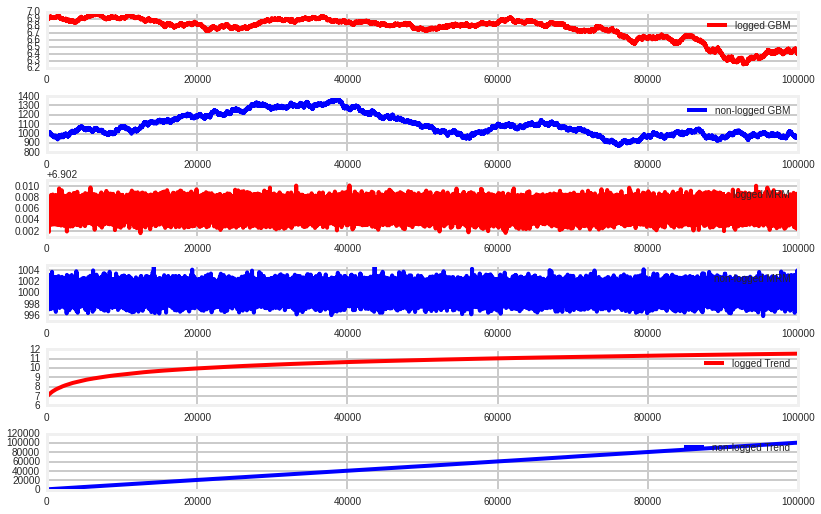

In [34]:
gbm1 = log(cumsum(randn(100000))+1000)
gbm2 = cumsum(randn(100000))+1000
mr1 = log(randn(100000)+1000)
mr2 = randn(100000)+1000
tr1 = log(cumsum(randn(100000)+1)+1000)
tr2 = cumsum(randn(100000)+1)+1000

fig = plt.figure(figsize=(12,8))

fig.add_subplot(611)
plot(gbm1,label="logged GBM",color="r")
legend()
fig.add_subplot(612)
plot(gbm2,label="non-logged GBM",color="b")
legend()
print "GBM: ",(HurstExponent(gbm1),HurstStationaryTest(gbm1)),(HurstExponent(gbm2),HurstStationaryTest(gbm2))

fig.add_subplot(613)
plot(mr1,label="logged MRM",color="r")
legend()
fig.add_subplot(614)
plot(mr2,label="non-logged MRM",color="b")
legend()
print "MRM: ",(HurstExponent(mr1),HurstStationaryTest(mr1)),(HurstExponent(mr2),HurstStationaryTest(mr2))

### a trend motion
fig.add_subplot(615)
plot(tr1,label="logged Trend",color="r")
legend()
fig.add_subplot(616)
plot(tr2,label="non-logged Trend",color="b")
legend()
print "Trend Motion: ",(HurstExponent(tr1),HurstStationaryTest(tr1)),(HurstExponent(tr2),HurstStationaryTest(tr2))                                                                                          


As it was claimed somewhere in the literature, the applying 'log' function is one of the ways to make the pseudo-stationary process from the GBM.

### ACF and PACF

-------------------------
The next step we want to perform is determining p and q orders of the ARMA.
First, it is worth to mention that hints on p and q can be obtained from ACF and PACF 
[[4]](#DeterminARMA).


In [ ]:
import statsmodels.api as sm
y=data['Close'].values
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
fig = sm.tsa.graphics.plot_acf(y, ax=axes[0], lags=40)
fig = sm.tsa.graphics.plot_pacf(y, ax=axes[1], lags=40)

This is a pattern of ARIMA(1,0,0). The main autocorrelation is the lag-1. We can test our observation by fitting the ARMA(2,0) and ARMA(1,0) (we expect to use it as our main choice) models and checking obtained parameters.

In [14]:
data = data.resample('D')
data.Close.interpolate(inplace=True) # missed data replacement
y=data.Close.values
arma_mod20 = sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css'))
arma_mod20.params

array([ 543.85977114,    1.08612941,   -0.12089564])

In [93]:
# here we estimate the GoF: AIC,BI and HQIC values
(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

(1757.477751352374, 1772.0736483050189, 1763.3295431756387)

Perhaps, ARMA(1,0) is better than ARMA(2,0)?

In [17]:
arma_mod10 = sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css'))
arma_mod10.params,(arma_mod10.aic, arma_mod10.bic, arma_mod10.hqic)

(array([ 544.37551321,    0.95056036]),
 (1317.0473706530292, 1326.8969818392432, 1321.0345667361255))

Please, put your attention on `trend='c'`. We use prior information from the ADF tests: the ADF `test-2` has  the smallest p-value of the stationarity. We expect to find the stationary trend with the intercept. Also it is possibe to ask statstools to find the orders of the ARMA.

In [58]:
# find the max order of ARMA
res = sm.tsa.arma_order_select_ic(y, max_ar=20, trend='c')
res

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

{'bic':               0            1            2
 0   2545.036739  2253.902049  2950.815273
 1   1770.588685  1772.530082  1777.078173
 2   1772.073648  1776.902022  1781.952478
 3   1776.878663          NaN          NaN
 4   1782.478397  1786.696686  1791.693169
 5   1788.119540  1793.910599  1799.536927
 6   1792.965890  1797.295983  1802.497423
 7   1797.743912  1802.689115  1802.020397
 8   1802.739020  1808.149882  1807.078981
 9   1808.055061  1813.665562  1812.159452
 10  1813.502226  1819.200105  1817.986995
 11  1817.641705  1822.625295  1823.450298
 12  1823.288194  1828.836614  1828.902281
 13  1826.947390  1832.341823  1835.462519
 14  1832.062693  1837.224355  1840.458865
 15  1837.095561  1842.719532          NaN
 16  1842.721024  1848.362269          NaN
 17  1848.369575  1854.011056  1859.096796
 18  1853.960216  1856.355721  1857.709891
 19  1859.228520  1861.644897  1867.475433
 20  1864.216947  1869.268148  1869.431804, 'bic_min_order': (1, 0)}

`res.bic_min_order` suggests to use ARMA(1,0).

In [59]:
res.bic_min_order

(1, 0)

Fit of the ARMA model
-----------------------------


-----------------------


We have already fitted the ARMA(1,0).

In [17]:
arma_mod10.params,arma_mod10.conf_int()

(array([ 544.34946821,    0.96932318]), array([[ 526.16488125,  562.53405518],
        [   0.94150758,    0.99713878]]))

-------------------------
#### Goodness of the Fit: Residual tests

##### a QQ-plot, D'Agostino's K-squared  and Durbin-Watson tests

-------------------------

After fitting  the model, we can make a simple GoF: check if the residuals are normal
distributed or not.



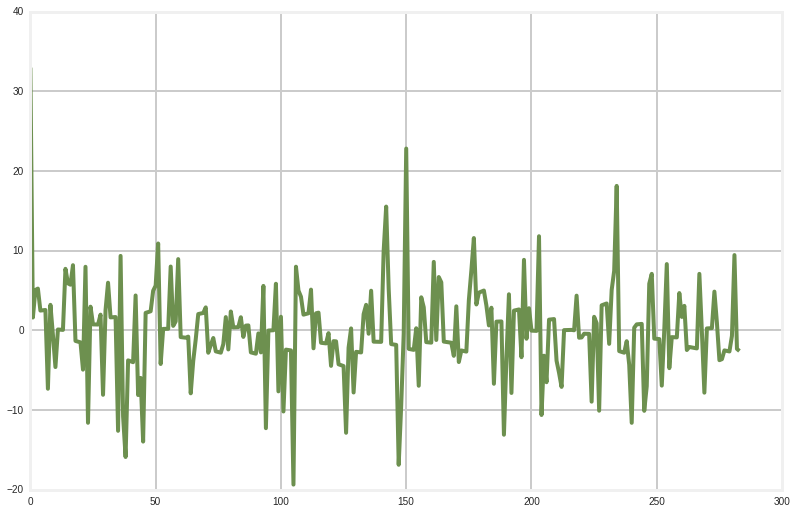

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plot(arma_mod10.resid)

The first test of the residual normality is a QQ-plot.

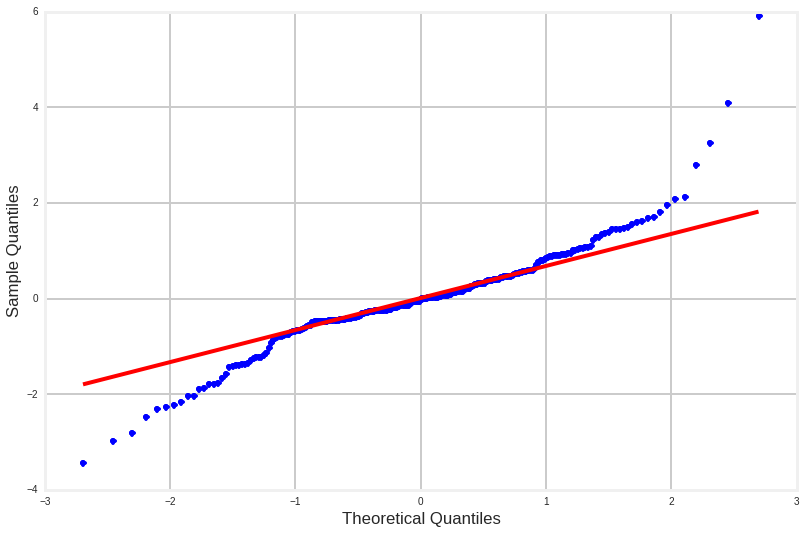

In [19]:
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(arma_mod10.resid, line='q', ax=ax, fit=True)

The QQ-plot indicates on NON-normality of the residuals. The D'Agostino's  $K^2$  test [[5]](#K2-test) statistic also proves this fact.

In [20]:
from scipy import stats
print 'K^2: {0}\np-value: {1}'.format(stats.normaltest(arma_mod10.resid)[0],stats.normaltest(arma_mod10.resid)[1])


K^2: 60.7740673728
p-value: 6.35446436512e-14


Also we check autocorrelations of the residuals, by  carring Durbin-Watson test:


In [18]:
d=sm.stats.durbin_watson(arma_mod10.resid)
print 'DW test: ', d


DW test:  1.78152012647


From the Durbin-Watson Significance Tables [[6]](#DW-Table), we conclude that there is a positive autocorrelation at 5% CL:

In [22]:
# 5% CL
DW_table_5cl={
    'dL': 1.758,
    'dU': 1.779
}

'''
To test for positive autocorrelation at significance α, the test statistic d is compared to lower and upper critical values (dL,α and dU,α):

        If d < dL,α, there is statistical evidence that the error terms are positively autocorrelated.
        If d > dU,α, there is no statistical evidence that the error terms are positively autocorrelated.
        If dL,α < d < dU,α, the test is inconclusive.

'''

print 'positively autocorrelated ', d<DW_table_5cl['dL']
print 'no statistical evidence about positively autocorrelation', d>DW_table_5cl['dU'] 
print 'inconclusive', (d<DW_table_5cl['dU'])  and  (d>DW_table_5cl['dL'])

positively autocorrelated  True
no statistical evidence about positively autocorrelation False
inconclusive False


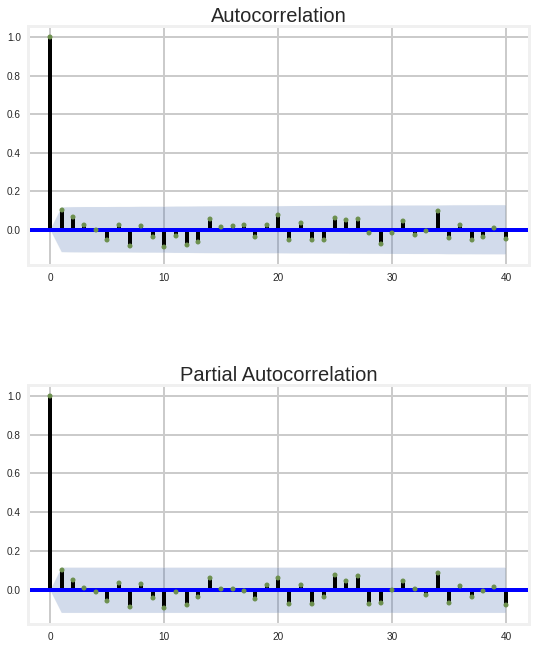

In [23]:
#ACF and PACF of the residuals
y=arma_mod10.resid
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
fig = sm.tsa.graphics.plot_acf(y, ax=axes[0], lags=40)
fig = sm.tsa.graphics.plot_pacf(y, ax=axes[1], lags=40)

Finally, we make the Ljung–Box (Q-statistic) test  [[7]](# Ljung–Box):

In [25]:
r,q,p = sm.tsa.acf(arma_mod10.resid, qstat=True)
statistics= np.c_[range(1,len(r)), r[1:], q, p]
table = pd.DataFrame(statistics, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

           AC          Q  Prob(>Q)
lag                               
1    0.052659   0.554628  0.456433
2    0.049134   1.039972  0.594529
3   -0.013800   1.078454  0.782278
4    0.048230   1.550957  0.817578
5   -0.115340   4.267236  0.511616
6   -0.004161   4.270789  0.640083
7   -0.080313   5.601674  0.586950
8   -0.106567   7.957260  0.437656
9   -0.055753   8.605451  0.474462
10   0.064066   9.465909  0.488530
11  -0.016445   9.522910  0.573742
12   0.009224   9.540940  0.656163
13   0.110948  12.163612  0.514275
14   0.033037  12.397431  0.574419
15  -0.054110  13.028109  0.600127
16   0.108786  15.591330  0.481828
17  -0.039348  15.928529  0.528907
18   0.038606  16.254946  0.574760
19   0.008747  16.271797  0.639073
20   0.022262  16.381561  0.692689
21  -0.097785  18.511432  0.616449
22  -0.017625  18.581023  0.671038
23   0.064117  19.507246  0.671423
24  -0.028627  19.692954  0.714096
25  -0.118277  22.881491  0.584483
26   0.097852  25.076623  0.514641
27   0.018252  25.15

We see that ARMA(1,0) fails at 10% CL (p-value of the Q statistic is 7% at the first lag).

Well. We see that GoF of the ARMA(1,0) is bad. We can fit a set of the ARMA models and find one with the best GoF.

Before we continue with the GoF class checker, we want to incorporate the HTML parser helping us to extract values of the  Durbin-Watson Significance Tables from online resource
http://web.stanford.edu/~clint/bench/.

In [19]:
from HTMLParser import HTMLParser
import urllib2


class MyHTMLParser(HTMLParser):
    ''' HTML parser: parses <pre> </pre> tags'''
    def __init__(self):
        HTMLParser.__init__(self)
        self.recording = 0
        self.data = []

    def handle_starttag(self, tag, attrs):
        if tag == 'pre':
                    self.recording = 1 

    def handle_endtag(self,tag):
        if tag == 'pre':
            self.recording -= 1

    def handle_data(self, data):
        if self.recording:
            self.data=data.split('\n')
        self.data=map(lambda x: x.split('  '), self.data)
        self.data=filter(lambda x: len(x)>2, self.data)




class Durbin_Watson_Table(object):
    ''' exctracts values for the table from html files '''
    def __init__(self,urls):
        self.table = []
        for url in urls:
            y = urllib2.urlopen(url)
            html = y.read()
            parser = MyHTMLParser()
            parser.feed(html)
            self.table+=parser.data
            parser.close()
            
dw=Durbin_Watson_Table(
    [
        'http://web.stanford.edu/~clint/bench/dw05a.htm',
        'http://web.stanford.edu/~clint/bench/dw05b.htm',
        'http://web.stanford.edu/~clint/bench/dw05c.htm',
        'http://web.stanford.edu/~clint/bench/dw05d.htm'
    ]

)
        

In [101]:
%history -f dw_table.py -l 1

In [20]:
# fix table: remove empty values and remove textual header 
import re
dw.table = [ filter(lambda x: len(x)>0, a) for a in dw.table] 
dw.table = [  map(lambda x: x.replace(' ',''), a) for a in dw.table]
headers = dw.table.pop(0) # gives the headers as list and leaves data
dw.table = filter(lambda x: re.search('\d+',' '.join(x)) is not None, dw.table) 
dw.table =  pd.DataFrame(dw.table, columns=headers,dtype='float')

In [21]:
def getLimits(dw,T,K):
    ''' return Watson-Durbin limits from table'''
    
    if (K<2): K=2
    T=T-T%10
    criteria = ((dw.table['T']==T) & (dw.table['K']==float(K)))
    return dw.table.loc[criteria]

Durbin_Watson_Table.getLimits = getLimits

In [23]:
def testDWStatistic(dw,T,K,d):
    ''' performs the test of the DW statistic '''
    
    result=np.array([[False,False,False],[False,False,False]])
    
    limits=dw.getLimits(T,K)
    if limits is None:return result
    a=len(limits)
    
    if a == 0: return result
    dL=limits.dL.values[0]
    dU=limits.dU.values[0]
    
    result=np.array([
                [d<=dL,d>=dU,(dL<d) & (d<dU)],
                [(4-d)<=dL,(4-d)>=dU,(dL<(4-d)) & ((4-d)<dU)]
            ])
    return result

def isPositiveCorrelationDWStatistic(dw,T,K,d):
    return dw.testDWStatistic(T,K,d)[0][0]

def isNegativeCorrelationDWStatistic(dw,T,K,d):
    return dw.testDWStatistic(T,K,d)[1][0]


Durbin_Watson_Table.testDWStatistic = testDWStatistic   
Durbin_Watson_Table.isPositiveCorrelationDWStatistic = isPositiveCorrelationDWStatistic   
Durbin_Watson_Table.isNegativeCorrelationDWStatistic = isNegativeCorrelationDWStatistic   

In [24]:
(dw.testDWStatistic(len(data),2,d),dw.isPositiveCorrelationDWStatistic(len(data),2,d),
dw.isNegativeCorrelationDWStatistic(len(data),2,d))


(array([[False,  True, False],
        [False,  True, False]], dtype=bool), False, False)

Our basic class for GoF calculation may look like this code.

In [62]:
## Class is responsible for GoF of the ARMA model
class GoF_ARMA(object):
    ''' GoF of the ARMA mode '''
    
    def __init__(self,model,order,DW_table,label='ARMA'):
        self.resid = model.resid
        self.bic = model.bic
        self.label = label
        self.order = order
        self.K2_Pval = stats.normaltest(self.resid) # normality test
        self.DW_Statistic = sm.stats.durbin_watson(self.resid) # autocorrelation test
        self.DW_Table=DW_table        
        self.DW_Test = (
                self.DW_Table.isPositiveCorrelationDWStatistic(len(self.resid),order+1,self.DW_Statistic),
                self.DW_Table.isNegativeCorrelationDWStatistic(len(self.resid),order+1,self.DW_Statistic)
            )
        r,q,p = sm.tsa.acf(self.resid, qstat=True)
        statistics_Ljung_Box= np.c_[range(1,len(r)), r[1:], q, p]
        self.Ljung_Box_Test = pd.DataFrame(statistics, columns=['lag', "AC", "Q", "Prob(>Q)"])
        self.Ljung_Box_Test.set_index('lag')        
        return
    
    
    def getGoFScore(self):
        ''' return the score related to GoF '''
        raise NotImplementedError(self.__class__.__name__ + '.getGoF')

                    

In [63]:
# our models that GoF to be tested

y=data.Close.values            
            
models_resid = [
                #  resid, sum of orders, label
            (sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css')),1,"arma10"),
            (sm.tsa.ARMA(y, (1,1)).fit(trend='c', fit_kw=dict(method='css')),2,"arma11"),
            (sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css')),2,"arma20"),
            (sm.tsa.ARMA(y, (2,1)).fit(trend='c', fit_kw=dict(method='css')),3,"arma21"),
            (sm.tsa.ARMA(y, (1,2)).fit(trend='c', fit_kw=dict(method='css')),3,"arma12"),
            (sm.tsa.ARMA(y, (3,0)).fit(trend='c', fit_kw=dict(method='css')),3,"arma30"),
        
          ]

The `GoFScore` is estimated using the following proporsal.

In [87]:
def getGoFScore(self,k2_pval_min=0.05,prob_q_min=0.10):
    ''' returns the score of the GoF '''    
    score = np.array([
        self.label,
        self.K2_Pval[1] > k2_pval_min,
        self.DW_Test[0] | self.DW_Test[1],
        len(self.Ljung_Box_Test.loc[self.Ljung_Box_Test['Prob(>Q)'] < prob_q_min]) > 0,
        self.bic    
            
        ])
    score=pd.DataFrame(np.array([score]),columns=['label', 'K2_Test', 'DW_Test', 'LB_Test','BIC'])
    score.set_index('label')
    return score
            
GoF_ARMA.getGoFScore = getGoFScore

In [88]:
model_gofs = map(lambda x: GoF_ARMA(x[0],x[1],dw,x[2]).getGoFScore() , models_resid)
model_gofs=pd.concat(model_gofs)
model_gofs.set_index('label')
model_gofs



label K2_Test DW_Test LB_Test            BIC
0  arma10   False   False   False  1326.89698184
0  arma11   False   False   False  1331.50389152
0  arma20   False   False   False  1331.42954808
0  arma21   False   False   False  1335.48894204
0  arma12   False   False   False  1336.26020502
0  arma30   False   False   False  1336.23976929

Seasonal Decomposition
----------------------------------


-------------


The seasonal decomposition is an another way of the modeling. We performs the fit in two steps: first we estimate trend (non-stationary part of the timeseries), then we calculate the stationary part of the process.

To make Seasonal Decomposition, one requires to do resampling the timeseries such the frequency is a days period (month?).

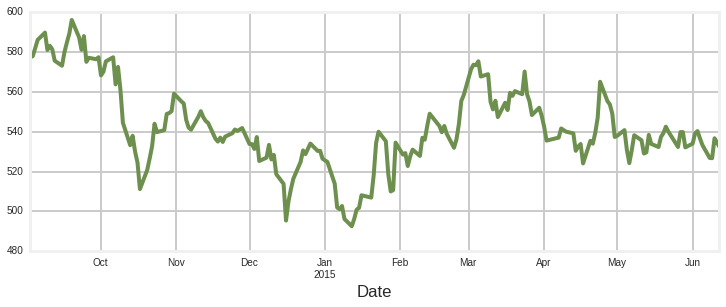

In [67]:
data = data.resample('D')
data.Close.interpolate(inplace=True)
data['Close'].plot()

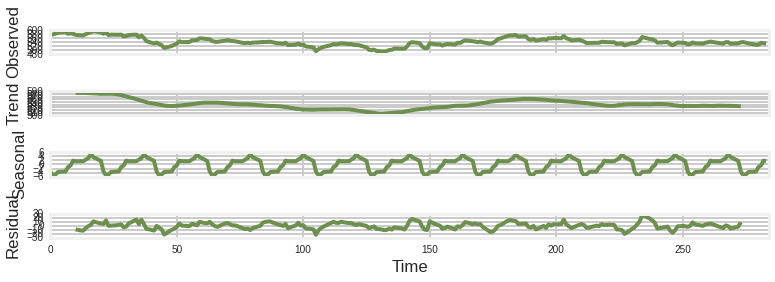

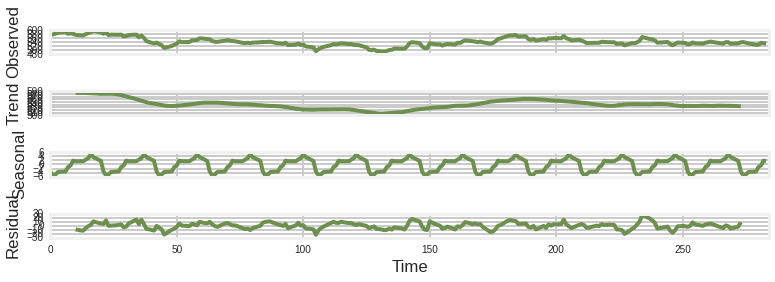

In [89]:
# we suggests that only 21 days in the month where the stock deals are being carried out.
res = sm.tsa.seasonal_decompose(data['Close'].values,freq=21) # find random noise, trend and cycle-component 
res.plot()

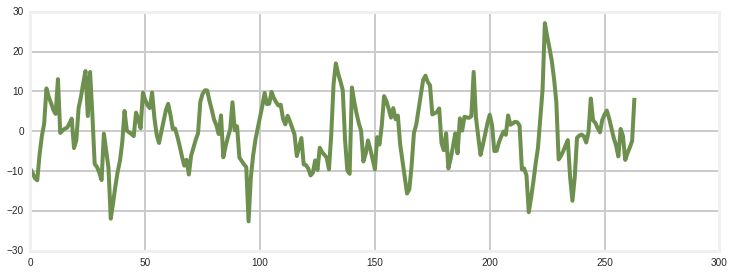

In [69]:
plot(pd.Series(res.resid).dropna()) 

Decomposition can be done also using the Hodrick-Prescott Filter:

In [71]:
res_cycle,res_trend = sm.tsa.filters.hpfilter(data['Close'].values) # find random noise, trend and cycle-component 

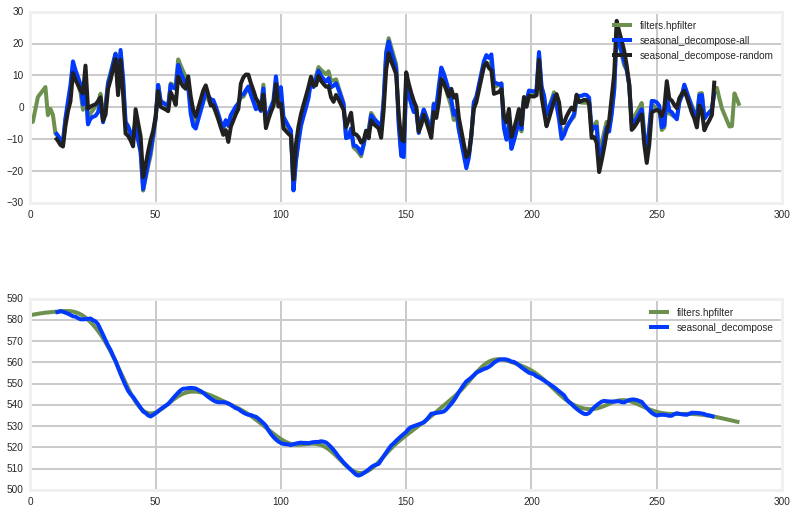

In [73]:
# we compare both approaches:
fig = plt.figure(figsize=(12,8))

# stationary process plot
ax1 = fig.add_subplot(211)
plot(res_cycle,label='filters.hpfilter')
plot(pd.Series(res.resid+res.seasonal),label='seasonal_decompose-all')
plot(pd.Series(res.resid),label='seasonal_decompose-random')
legend()

# trend plot
ax2 = fig.add_subplot(212)
plot(res_trend,label='filters.hpfilter')
plot(res.trend,label='seasonal_decompose')
legend()

In [74]:
# consistence check
print len(data)
print res_trend.size
print res.trend.size
print res.resid.size
print len(res.resid[np.isnan(res.resid)]) # how many NaN do we have?

284
284
284
284
20


Let's plot ACF and PACF for random part of the decomposition:

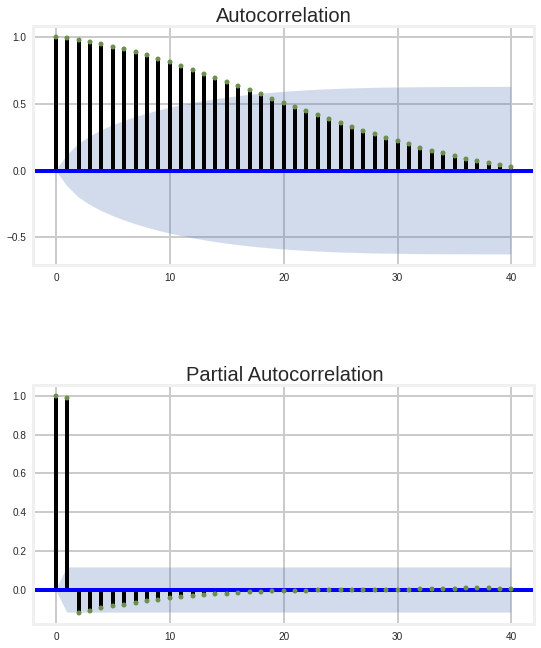

In [75]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
y= res_trend
fig = sm.tsa.graphics.plot_acf(y, ax=axes[0], lags=40)
fig = sm.tsa.graphics.plot_pacf(y, ax=axes[1], lags=40)

Let's make an ADF test on decomposed timeseries.

In [90]:
# trend test
y= res_trend
# test 1
unit_root1 = sm.tsa.adfuller(y,maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 1: ', unit_root1

# test 2
unit_root2 = sm.tsa.adfuller(y,maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 2: ', unit_root2


# test 3
unit_root3 = sm.tsa.adfuller(y,maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 3: ', unit_root3



ADF test 1:  (-0.92496410910061477, 0.31856462868556068, 4, 279, {'5%': -1.9420045154816323, '1%': -2.5738002150537636, '10%': -1.6159017267199256}, -2402.1453837932663)


ADF test 2:  (-2.862360294580891, 0.04990332939642491, 4, 279, {'5%': -2.8719557347997178, '1%': -3.4540076534999957, '10%': -2.5723200648758366}, -2407.7397343063635)


ADF test 3:  (-2.6510739894489226, 0.25695280421028915, 4, 279, {'5%': -3.4263443727704468, '1%': -3.9915897703304672, '10%': -3.1363688373100778}, -2405.8624217924726)


The test indicates about non-stationary process for the trend.

In [91]:
# stationary process test
y= res_cycle
# test 1
unit_root1 = sm.tsa.adfuller(y,maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 1: ', unit_root1

# test 2
unit_root2 = sm.tsa.adfuller(y,maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 2: ', unit_root2


# test 3
unit_root3 = sm.tsa.adfuller(y,maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
print '\n\nADF test 3: ', unit_root3



ADF test 1:  (-7.0975632122803543, 3.6596369405973168e-11, 9, 274, {'5%': -1.9420235953892757, '1%': -2.5739481650594063, '10%': -1.6158855739604792}, 1600.9309418465634)


ADF test 2:  (-7.0841222556104482, 4.5852810706223691e-10, 9, 274, {'5%': -2.8721468827772774, '1%': -3.4544435065994437, '10%': -2.572422013959188}, 1602.9259314043188)


ADF test 3:  (-7.0705296064250014, 9.7795594845121638e-09, 9, 274, {'5%': -3.4266359214468025, '1%': -3.9921956888591335, '10%': -3.1365398646549112}, 1604.9151048151948)


As expected, the ADF test indicates the stationarity of the `res_cycle`.
Can we model `trend` and `cycle` parts with ARMA?

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


label K2_Test DW_Test LB_Test             BIC
0  arma10   False    True   False   747.865409568
0  arma20   False    True   False  -538.421911737
0  arma30   False    True   False  -1505.43040631

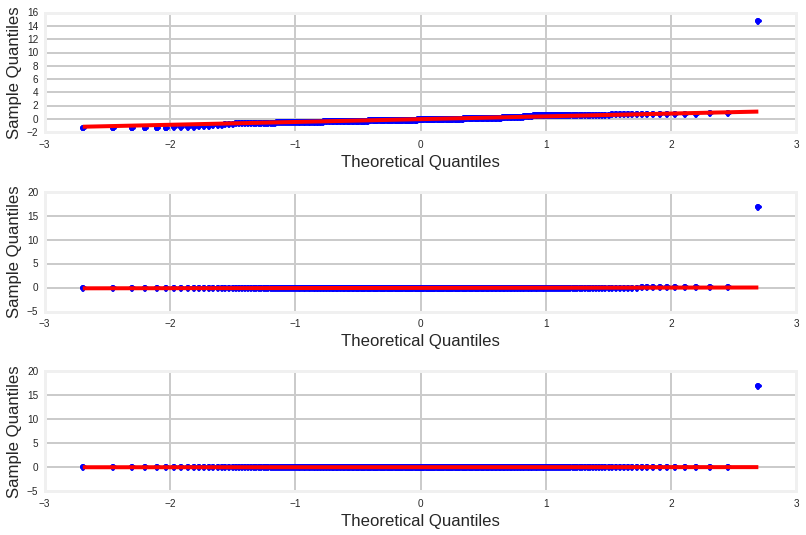

In [102]:
# our models that GoF to be tested

y=res_trend           
            
models_resid = [
                #  resid, sum of orders, label
            (sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css')),1,"arma10"),
            #(sm.tsa.ARMA(y, (1,1)).fit(trend='c', fit_kw=dict(method='css')),2,"arma11"),
            (sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css')),2,"arma20"),
            #(sm.tsa.ARMA(y, (2,1)).fit(trend='c', fit_kw=dict(method='css')),3,"arma21"),
            #(sm.tsa.ARMA(y, (1,2)).fit(trend='c', fit_kw=dict(method='css')),3,"arma12"),
            (sm.tsa.ARMA(y, (3,0)).fit(trend='c', fit_kw=dict(method='css')),3,"arma30"),
        
          ]

model_gofs = map(lambda x: GoF_ARMA(x[0],x[1],dw,x[2]).getGoFScore() , models_resid)
model_gofs=pd.concat(model_gofs)
model_gofs.set_index('label')

# QQ-plots
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(311)
fig = qqplot(sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)
ax = fig.add_subplot(312)
fig = qqplot(sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)
ax = fig.add_subplot(313)
fig = qqplot(sm.tsa.ARMA(y, (3,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)

model_gofs

label K2_Test DW_Test LB_Test            BIC
0  arma10   False    True   False  1722.81861524
0  arma11   False   False   False  1722.65281939
0  arma20   False   False   False  1720.89641189
0  arma21   False   False   False  1684.40237692
0  arma12   False   False   False  1725.34272719
0  arma30   False   False   False  1722.35443684

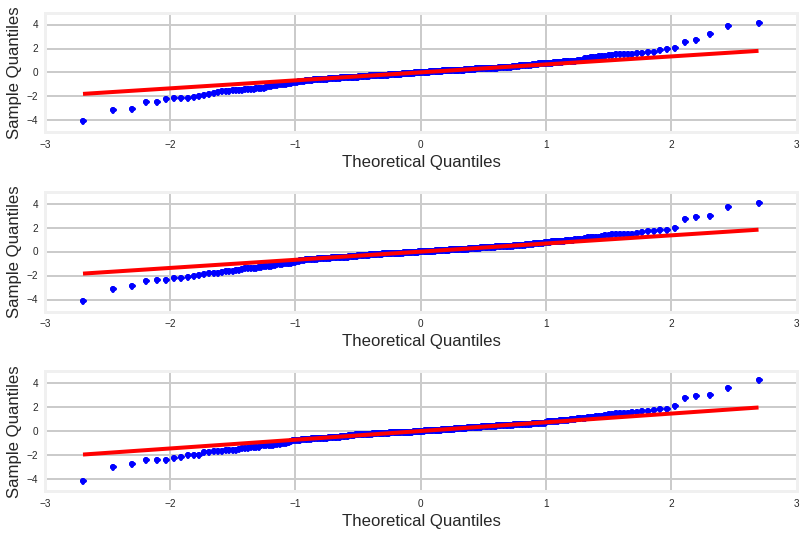

In [104]:
# our models that GoF to be tested

y=res_cycle
            
models_resid = [
                #  resid, sum of orders, label
            (sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css')),1,"arma10"),
            (sm.tsa.ARMA(y, (1,1)).fit(trend='c', fit_kw=dict(method='css')),2,"arma11"),
            (sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css')),2,"arma20"),
            (sm.tsa.ARMA(y, (2,1)).fit(trend='c', fit_kw=dict(method='css')),3,"arma21"),
            (sm.tsa.ARMA(y, (1,2)).fit(trend='c', fit_kw=dict(method='css')),3,"arma12"),
            (sm.tsa.ARMA(y, (3,0)).fit(trend='c', fit_kw=dict(method='css')),3,"arma30"),
        
          ]

model_gofs = map(lambda x: GoF_ARMA(x[0],x[1],dw,x[2]).getGoFScore() , models_resid)
model_gofs=pd.concat(model_gofs)
model_gofs.set_index('label')

# QQ-plots
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(311)
fig = qqplot(sm.tsa.ARMA(y, (1,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)
ax = fig.add_subplot(312)
fig = qqplot(sm.tsa.ARMA(y, (2,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)
ax = fig.add_subplot(313)
fig = qqplot(sm.tsa.ARMA(y, (3,0)).fit(trend='c', fit_kw=dict(method='css')).resid, line='q', ax=ax, fit=True)

model_gofs

The best choice for modeling of the decomposed timeseries is the following:

* ARMA(1,0) for a trend
* ARMA(2,1) for a cycle

Forecasting using ARMA
-----------------------------------------------------

-----------------------


We try to forecast the the `Close` price w/ and w/o seasonal decomposition. Then we would like to compare obtained results. Also we would test `One-step-ahead forecast` and 
`Dynamic forecast`.




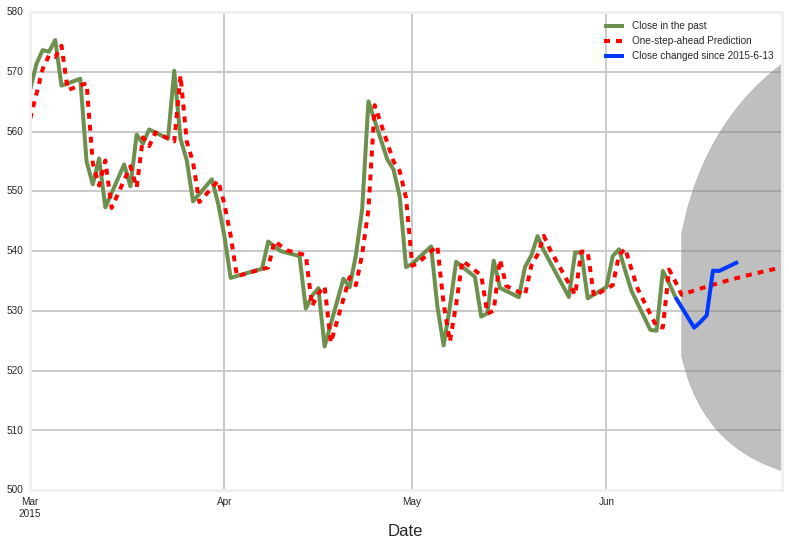

In [309]:
# One-step-ahead forecast of 'Close' price w/o seasonal decomposition

npredict=17 # how many days do we want to predict price for? Let's predict to the end of the June 2015 
start = '2015-3-1'    # some day in the past
today = '2015-6-13'   #  today is 13th June of 2015.
future = today.split('-')
future[2] = str(int(future[2]) + npredict-1)
future = '-'.join(future)

data_close_price=data['Close'].dropna()
arma10=sm.tsa.ARMA(data_close_price, (1,0)).fit()
predictions_onestep=arma10.predict(start=start,end=future)
ax = data_close_price.ix['2015-3-1':].plot(figsize=(12,8),label='Close in the past')
ax = predictions_onestep.plot(ax=ax, style='r--', label='One-step-ahead Prediction');

# forecast out of sample prices
# we will use CI of 95%CL
_, _, conf_int = arma10.forecast(npredict,alpha=0.05)
_ = ax.fill_between(predictions_onestep.ix[today:].index, conf_int[:, 0], conf_int[:, 1],
                    color='gray', alpha=.5,label='Uncertainty')


start_in_reality = datetime.datetime(2015,6,13-1)  #  today in our example is 13th June of 2015.
today_in_reality =  datetime.datetime(2015,6,23) # upto-dated 'today'

data_reality = web.DataReader("GOOG", 'yahoo', start_in_reality, today_in_reality)
data_reality['Close'].plot(label='Close changed since 2015-6-13')

ax.legend();


So, we have made a first prediction with ARMA(1,0) using  `One-step-ahead` forecast, and we have got interesting results:

* The positive side: our predictions of the `Close` price for the time period [2015-6-12,2015-6-23] are in a good agreement with real-life `Close` prices. Is it a coincedence?

* The negative side: our predictions are too uncertain.

Could we reduce the error by applying another method?

Let's try dynamic forecast.

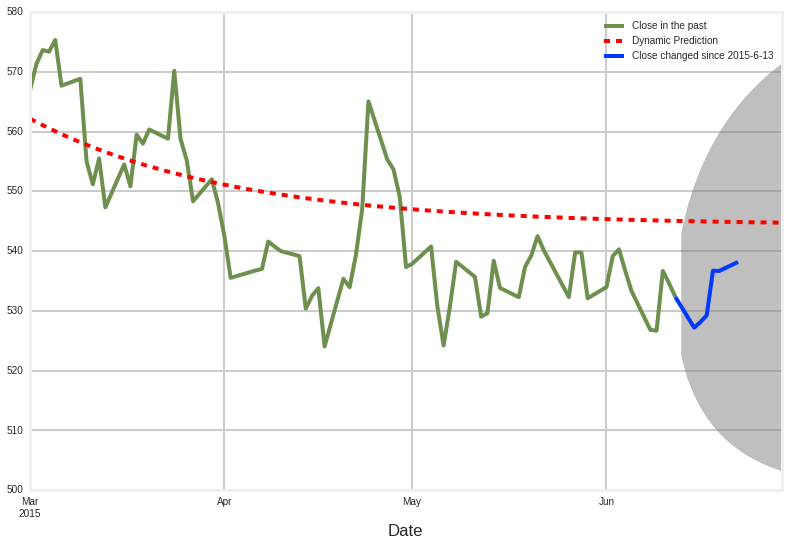

In [310]:
# Dynamic forecast of 'Close' price w/o seasonal decomposition

npredict=17 # how many days do we want to predict price for? Let's predict to the end of the June 2015 
start = '2015-3-1'    # some day in the past
today = '2015-6-13'   #  today is 13th June of 2015.
future = today.split('-')
future[2] = str(int(future[2]) + npredict-1)
future = '-'.join(future)

data_close_price=data['Close'].dropna()
arma10=sm.tsa.ARMA(data_close_price, (1,0)).fit()
predictions_dynamic=arma10.predict(start=start,end=future,dynamic=True)
ax = data_close_price.ix['2015-3-1':].plot(figsize=(12,8),label='Close in the past')
ax = predictions_dynamic.plot(ax=ax, style='r--', label='Dynamic Prediction');

# forecast out of sample prices
# we will use CI of 95%CL
_, _, conf_int = arma10.forecast(npredict,alpha=0.05)
_ = ax.fill_between(predictions_dynamic.ix[today:].index, conf_int[:, 0], conf_int[:, 1],
                    color='gray', alpha=.5,label='Uncertainty')


start_in_reality = datetime.datetime(2015,6,13-1)  #  today in our example is 13th June of 2015.
today_in_reality =  datetime.datetime(2015,6,23) # upto-dated 'today'

data_reality = web.DataReader("GOOG", 'yahoo', start_in_reality, today_in_reality)
data_reality['Close'].plot(label='Close changed since 2015-6-13')

ax.legend();


As expected, dynamic predictions are failed for non-stationary process. 


Let's go further and do predictions for the decomposition of timeseries.

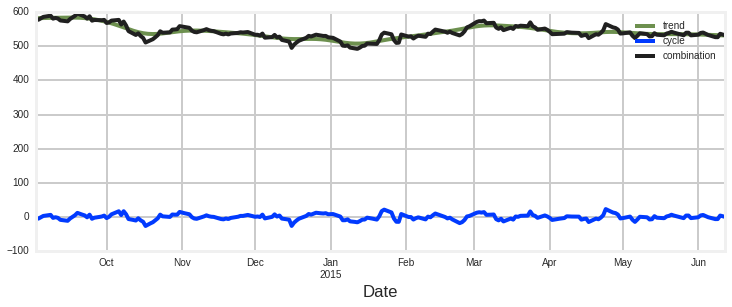

In [311]:
# Seasonal decomposition

data_close_price=data['Close'].dropna()
res_cycle,res_trend = sm.tsa.filters.hpfilter(data_close_price) # find random noise, trend and cycle-component 
res_trend.plot(label='trend')
res_cycle.plot(label='cycle')
(res_cycle+res_trend).plot(label='combination')
legend()

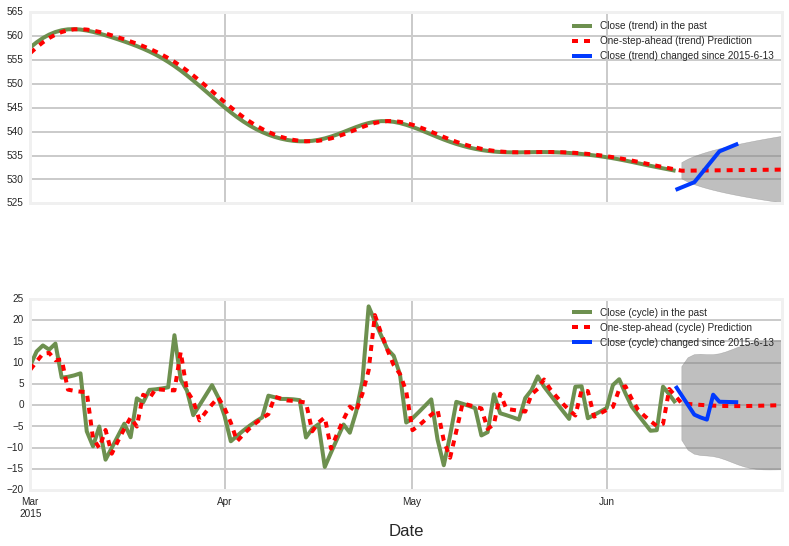

In [312]:
# One-step-ahead forecast of 'Close' price w/ the seasonal decomposition

npredict=17 # how many days do we want to predict price for? Let's predict to the end of the June 2015 
start = '2015-3-1'    # some day in the past
today = '2015-6-13'   #  today is 13th June of 2015.
future = today.split('-')
future[2] = str(int(future[2]) + npredict-1)
future = '-'.join(future)

# our models
arma10_trend=sm.tsa.ARMA(res_trend, (1,0)).fit()
arma21_cycle=sm.tsa.ARMA(res_cycle, (2,1)).fit()


trend_predictions_onestep=arma10_trend.predict(start=start,end=future)
cycle_predictions_onestep=arma21_cycle.predict(start=start,end=future)


start_in_reality = datetime.datetime(2015,6,13-1)  #  today in our example is 13th June of 2015.
today_in_reality =  datetime.datetime(2015,6,23) # upto-dated 'today'

data_reality = web.DataReader("GOOG", 'yahoo', start_in_reality, today_in_reality)

data_close_price_reality=data_reality['Close'].dropna()
res_cycle_reality,res_trend_reality = sm.tsa.filters.hpfilter(data_close_price_reality) # find random noise, trend and cycle-component 


# plot trend
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
res_trend.ix['2015-3-1':].plot(figsize=(12,8),label='Close (trend) in the past')
trend_predictions_onestep.plot(ax=ax, style='r--', label='One-step-ahead (trend) Prediction');
_, _, conf_int_trend = arma10_trend.forecast(npredict,alpha=0.05)
_ = ax.fill_between(trend_predictions_onestep.ix[today:].index, conf_int_trend[:, 0], conf_int_trend[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')
res_trend_reality.plot(label='Close (trend) changed since 2015-6-13')
legend()


# plot stationary part
ax = fig.add_subplot(212)
res_cycle.ix['2015-3-1':].plot(figsize=(12,8),label='Close (cycle) in the past')
cycle_predictions_onestep.plot(ax=ax, style='r--', label='One-step-ahead (cycle) Prediction');
_, _, conf_int_cycle = arma21_cycle.forecast(npredict,alpha=0.05)
_ = ax.fill_between(cycle_predictions_onestep.ix[today:].index, conf_int_cycle[:, 0], conf_int_cycle[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')
res_cycle_reality.plot(label='Close (cycle) changed since 2015-6-13')
legend()



The results are now much better than in the case of the model without the seasonal decomposition:

* The total uncertainty of the model becomes smaller.
* The stationary part of the price movement is more reliable.

We want to combine our predictions in one set and compare with the actual price asset.


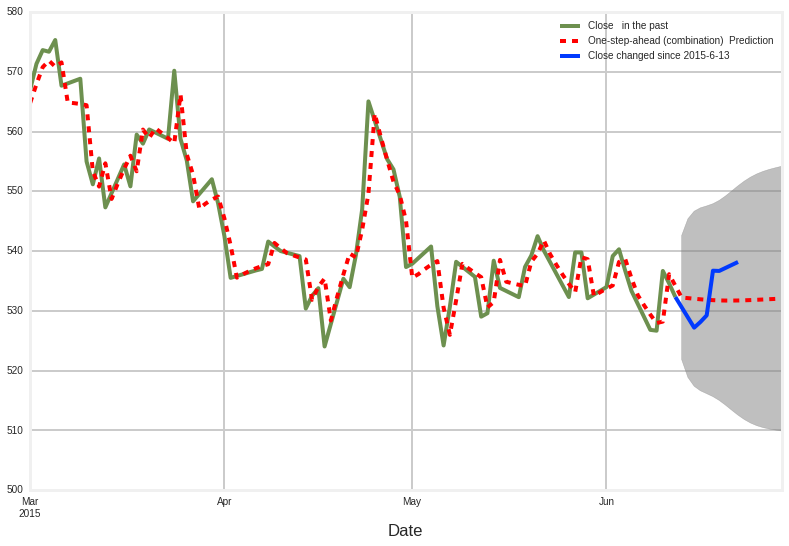

In [313]:
ax=(res_trend+res_cycle).ix['2015-3-1':].plot(figsize=(12,8),label='Close   in the past')
(cycle_predictions_onestep+trend_predictions_onestep).plot(ax=ax, style='r--', label='One-step-ahead (combination)  Prediction');


conf_int=conf_int_trend+conf_int_cycle # very conservative!


_ = ax.fill_between((cycle_predictions_onestep+trend_predictions_onestep).ix[today:].index, conf_int[:, 0], conf_int[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')


start_in_reality = datetime.datetime(2015,6,13-1)  #  today in our example is 13th June of 2015.
today_in_reality =  datetime.datetime(2015,6,23) # upto-dated 'today'

data_reality = web.DataReader("GOOG", 'yahoo', start_in_reality, today_in_reality)
data_reality['Close'].plot(label='Close changed since 2015-6-13')

ax.legend();



Finally, we want to test dynamic modeling and decomposition. We predict dynamically only stationary part!

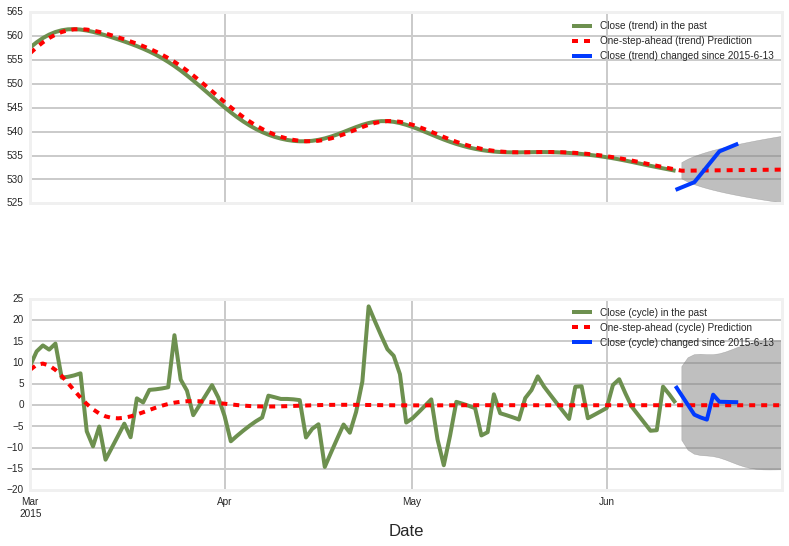

In [314]:
trend_predictions_onestep=arma10_trend.predict(start=start,end=future,dynamic=False)
cycle_predictions_onestep=arma21_cycle.predict(start=start,end=future,dynamic=True)


# plot trend
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
res_trend.ix['2015-3-1':].plot(figsize=(12,8),label='Close (trend) in the past')
trend_predictions_onestep.plot(ax=ax, style='r--', label='One-step-ahead (trend) Prediction');
_, _, conf_int_trend = arma10_trend.forecast(npredict,alpha=0.05)
_ = ax.fill_between(trend_predictions_onestep.ix[today:].index, conf_int_trend[:, 0], conf_int_trend[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')
res_trend_reality.plot(label='Close (trend) changed since 2015-6-13')
legend()


# plot stationary part
ax = fig.add_subplot(212)
res_cycle.ix['2015-3-1':].plot(figsize=(12,8),label='Close (cycle) in the past')
cycle_predictions_onestep.plot(ax=ax, style='r--', label='One-step-ahead (cycle) Prediction');
_, _, conf_int_cycle = arma21_cycle.forecast(npredict,alpha=0.05)
_ = ax.fill_between(cycle_predictions_onestep.ix[today:].index, conf_int_cycle[:, 0], conf_int_cycle[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')
res_cycle_reality.plot(label='Close (cycle) changed since 2015-6-13')
legend()

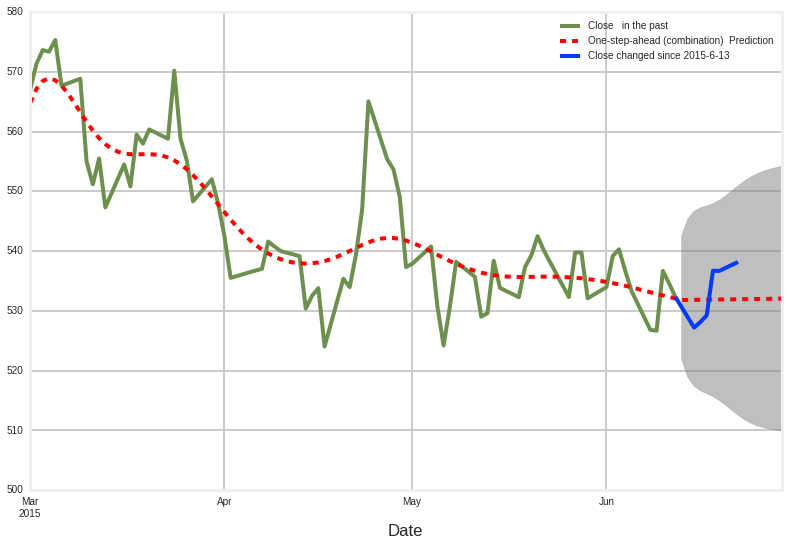

In [315]:
ax=(res_trend+res_cycle).ix['2015-3-1':].plot(figsize=(12,8),label='Close   in the past')
(cycle_predictions_onestep+trend_predictions_onestep).plot(ax=ax, style='r--', label='One-step-ahead (combination)  Prediction');
conf_int=conf_int_trend+conf_int_cycle # very conservative!
_ = ax.fill_between((cycle_predictions_onestep+trend_predictions_onestep).ix[today:].index, conf_int[:, 0], conf_int[:, 1],
                   color='gray', alpha=.5,label='Uncertainty')


start_in_reality = datetime.datetime(2015,6,13-1)  #  today in our example is 13th June of 2015.
today_in_reality =  datetime.datetime(2015,6,23) # upto-dated 'today'

data_reality = web.DataReader("GOOG", 'yahoo', start_in_reality, today_in_reality)
data_reality['Close'].plot(label='Close changed since 2015-6-13')

ax.legend();

It looks like the result of the Kalman Filter which I have presented in my previous presentation. Also we want to estimate the gredient of the current trend.

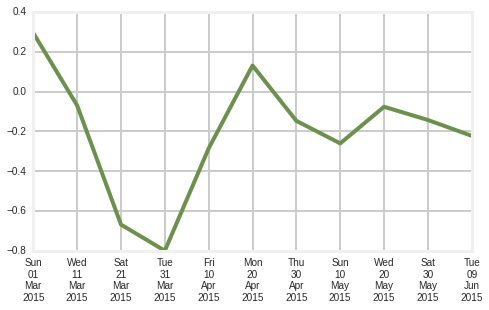

In [316]:
def derivative(f):
    """....Computes the numerical derivative of a function. """

    def df(x, h=0.1e-5):
        return ( f(x+h/2) - f(x-h/2) )/h
    return df

# sample function
def g(x): return x*x*x


start_day='2015-3-1'
ax2 = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
indexes=[res_trend.ix[start_day:].index[x].strftime('%a\n%d\n%h\n%Y') for x in range(0,len(res_trend.ix[start_day:].index),10)]
x = np.linspace(0,len(indexes),len(indexes))
xticks(np.arange(0,len(indexes)))
dx = (x[1]-x[0])*10
y=np.array([res_trend.ix[start_day:][x] for x in range(0,len(res_trend.ix[start_day:].index),10)])
dydx = np.gradient(y, dx)

ax2.plot(dydx)
b=ax2.set_xticklabels(indexes) # location, labels


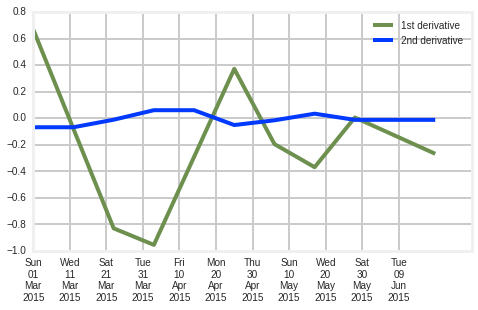

In [317]:
# another way to plot gradient
from scipy.interpolate import splrep, splev


start_day='2015-3-1'


ax2 = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
x = np.linspace(0,len(indexes),len(indexes))
y=np.array([res_trend.ix[start_day:][i] for i in range(0,len(res_trend.ix[start_day:].index),10)])
f = splrep(x,y,k=2,s=2)
plt.plot(x, splev(x,f,der=1)/10, label="1st derivative")
plt.plot(x, splev(x,f,der=2)/100, label="2nd derivative")
xticks(np.arange(0,len(indexes)))
b=ax2.set_xticklabels(indexes) # location, labels
legend()

It looks like the trend gradient is zero at this moment.

Forecasts using ARIMA (optional)
-------------------------


------------------


References
----------------------

-------


<a id='AR'></a>
[[1] Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)


<a id='MA'></a>
[[2]Moving-average model](https://en.wikipedia.org/wiki/Moving-average_model)

<a id='ADF'></a>
[[3]ADF test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

<a id='DeterminARMA'></a>
[[4]Identifying the numbers of AR or MA terms in an ARIMA model](http://people.duke.edu/~rnau/411arim3.htm)

<a id='K2-test'></a>
[[5]D'Agostino's K-squared test ](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test)

<a id='DW-Table'></a>
[[6]Durbin-Watson Significance Tables](https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf)

<a id='Ljung–Box'></a>
[[7]Ljung–Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)